## 1. Data

In [1]:
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=101)

In [3]:
print(X[:5])
print(y[:5])

[[ 0.67621763  0.49758361]
 [-0.81272345 -0.54300962]
 [ 0.19260493  1.0200862 ]
 [-0.3206205  -0.69172039]
 [-0.77961897  0.64546739]]
[1 0 0 1 0]


In [4]:
import pandas as pd
df = pd.DataFrame({"X1":X[:,0],
                   "X2":X[:,1],
                   "y":y})

In [5]:
df.head()

,X1,X2,y
0,0.676218,0.497584,1
1,-0.812723,-0.543010,0
2,0.192605,1.020086,0
3,-0.320621,-0.691720,1
4,-0.779619,0.645467,0


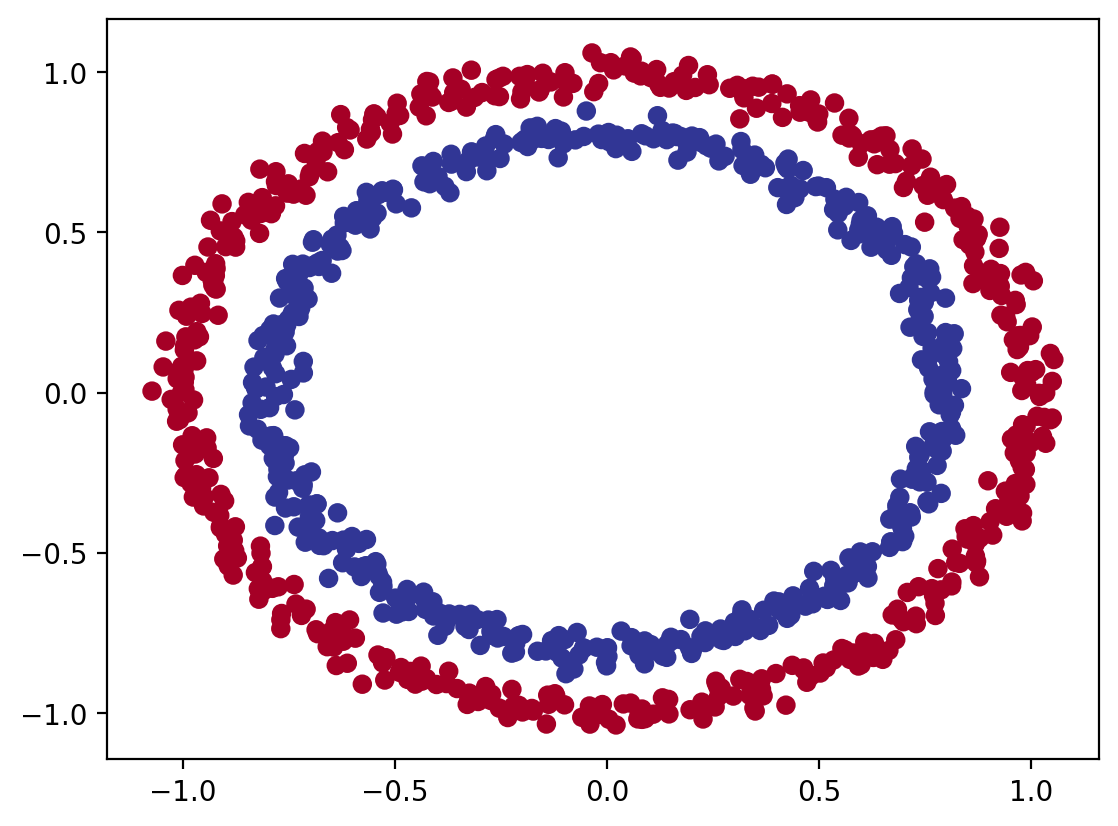

In [6]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.scatter(X[:,0],
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Getting Data shape

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X[0], y[0]

(array([0.67621763, 0.49758361]), 1)

### 1.2 Turning data into tensors and create train test splits

In [9]:
import torch

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
X[:5]

tensor([[ 0.6762,  0.4976],
        [-0.8127, -0.5430],
        [ 0.1926,  1.0201],
        [-0.3206, -0.6917],
        [-0.7796,  0.6455]])

In [12]:
y[:5]

tensor([1., 0., 0., 1., 0.])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Model

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
device

'cuda'

In [17]:
X_train

tensor([[ 0.7188,  0.7079],
        [-0.6947,  0.4689],
        [ 0.1889,  0.7502],
        ...,
        [-0.2578, -0.7658],
        [-0.4184,  0.9685],
        [-0.1643,  0.8304]])

In [18]:
class CircleModelV0(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linearlayer1 = torch.nn.Linear(in_features=2,
                                            out_features=5)
        self.linearlayer2 = torch.nn.Linear(in_features=5, 
                                            out_features=1)
    def forward(self, x):
        return self.linearlayer2(self.linearlayer1(x))

model_0 = CircleModelV0()
model_0.to(device=device)
print(next(model_0.parameters()).device)

cuda:0


In [19]:
model_0 = torch.nn.Sequential(torch.nn.Linear(in_features=2,
                                              out_features=5),
                              torch.nn.Linear(in_features=5,
                                              out_features=1))
model_0.to(device=device)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4508,  0.2856],
                      [ 0.4573,  0.2203],
                      [ 0.0129,  0.5234],
                      [-0.4660,  0.6354],
                      [ 0.4777,  0.5229]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4912,  0.4340,  0.5520, -0.3455,  0.3114], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3143, -0.3497,  0.0098,  0.2336, -0.0739]], device='cuda:0')),
             ('1.bias', tensor([-0.0103], device='cuda:0'))])

In [21]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device=device))
print(untrained_preds[:10])

tensor([[-0.0003],
        [ 0.0300],
        [ 0.0276],
        [-0.0282],
        [ 0.0442],
        [-0.0304],
        [ 0.0615],
        [-0.2710],
        [-0.2253],
        [-0.0344]], device='cuda:0')


In [22]:
torch.round(untrained_preds[:10])

tensor([[-0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [-0.],
        [-0.],
        [-0.]], device='cuda:0')

In [23]:
y_test[:10]

tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 0.])

In [24]:
loss_fn = torch.nn.BCEWithLogitsLoss() # More numerically stable as it combines sigmoid along with binary cross entropy
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [25]:
def accuracy_fn(y_preds, y_true):
    correct = torch.eq(y_preds, y_true).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

## 3. Train Model

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels
Logits are the raw outputs from the mode.

Prediction probabilities are logits + some activation function (sigmoid or softmax)

In [26]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0003],
        [ 0.0300],
        [ 0.0276],
        [-0.0282],
        [ 0.0442]], device='cuda:0')

In [27]:
# Logits to probabilites
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4999],
        [0.5075],
        [0.5069],
        [0.4930],
        [0.5110]], device='cuda:0')

In [28]:
# Probabilities to labels
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [29]:
# All the steps in one line
y_preds = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))
y_preds

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)

### 3.2 Building a Training Loop

In [30]:
torch.cuda.manual_seed(101)
torch.manual_seed(101)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    train_logits = model_0(X_train).squeeze()
    train_preds = torch.round(torch.sigmoid(train_logits))

    train_loss = loss_fn(train_logits, y_train) # BCEwithlogitsloss expects raw logits as inputs
    train_accuracy = accuracy_fn(train_preds, y_train)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(test_preds, y_test)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Training Loss: {train_loss:.5f} | Training Accuracy: {train_accuracy:.2f}% | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_accuracy:.2f}%")

Epoch: 0 | Training Loss: 0.69719 | Training Accuracy: 45.12% | Testing Loss: 0.69188 | Testing Accuracy: 50.00%
Epoch: 10 | Training Loss: 0.69425 | Training Accuracy: 48.62% | Testing Loss: 0.69410 | Testing Accuracy: 51.00%
Epoch: 20 | Training Loss: 0.69334 | Training Accuracy: 50.75% | Testing Loss: 0.69587 | Testing Accuracy: 48.00%
Epoch: 30 | Training Loss: 0.69304 | Training Accuracy: 53.62% | Testing Loss: 0.69697 | Testing Accuracy: 46.00%
Epoch: 40 | Training Loss: 0.69292 | Training Accuracy: 54.12% | Testing Loss: 0.69759 | Testing Accuracy: 46.00%
Epoch: 50 | Training Loss: 0.69287 | Training Accuracy: 56.62% | Testing Loss: 0.69791 | Testing Accuracy: 49.50%
Epoch: 60 | Training Loss: 0.69283 | Training Accuracy: 60.62% | Testing Loss: 0.69806 | Testing Accuracy: 52.50%
Epoch: 70 | Training Loss: 0.69281 | Training Accuracy: 58.88% | Testing Loss: 0.69811 | Testing Accuracy: 51.50%
Epoch: 80 | Training Loss: 0.69279 | Training Accuracy: 57.38% | Testing Loss: 0.69812 | 

## 4. Make predictions and evaluate the model

In [31]:
import requests
from pathlib import Path

# Download helpwe functions
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


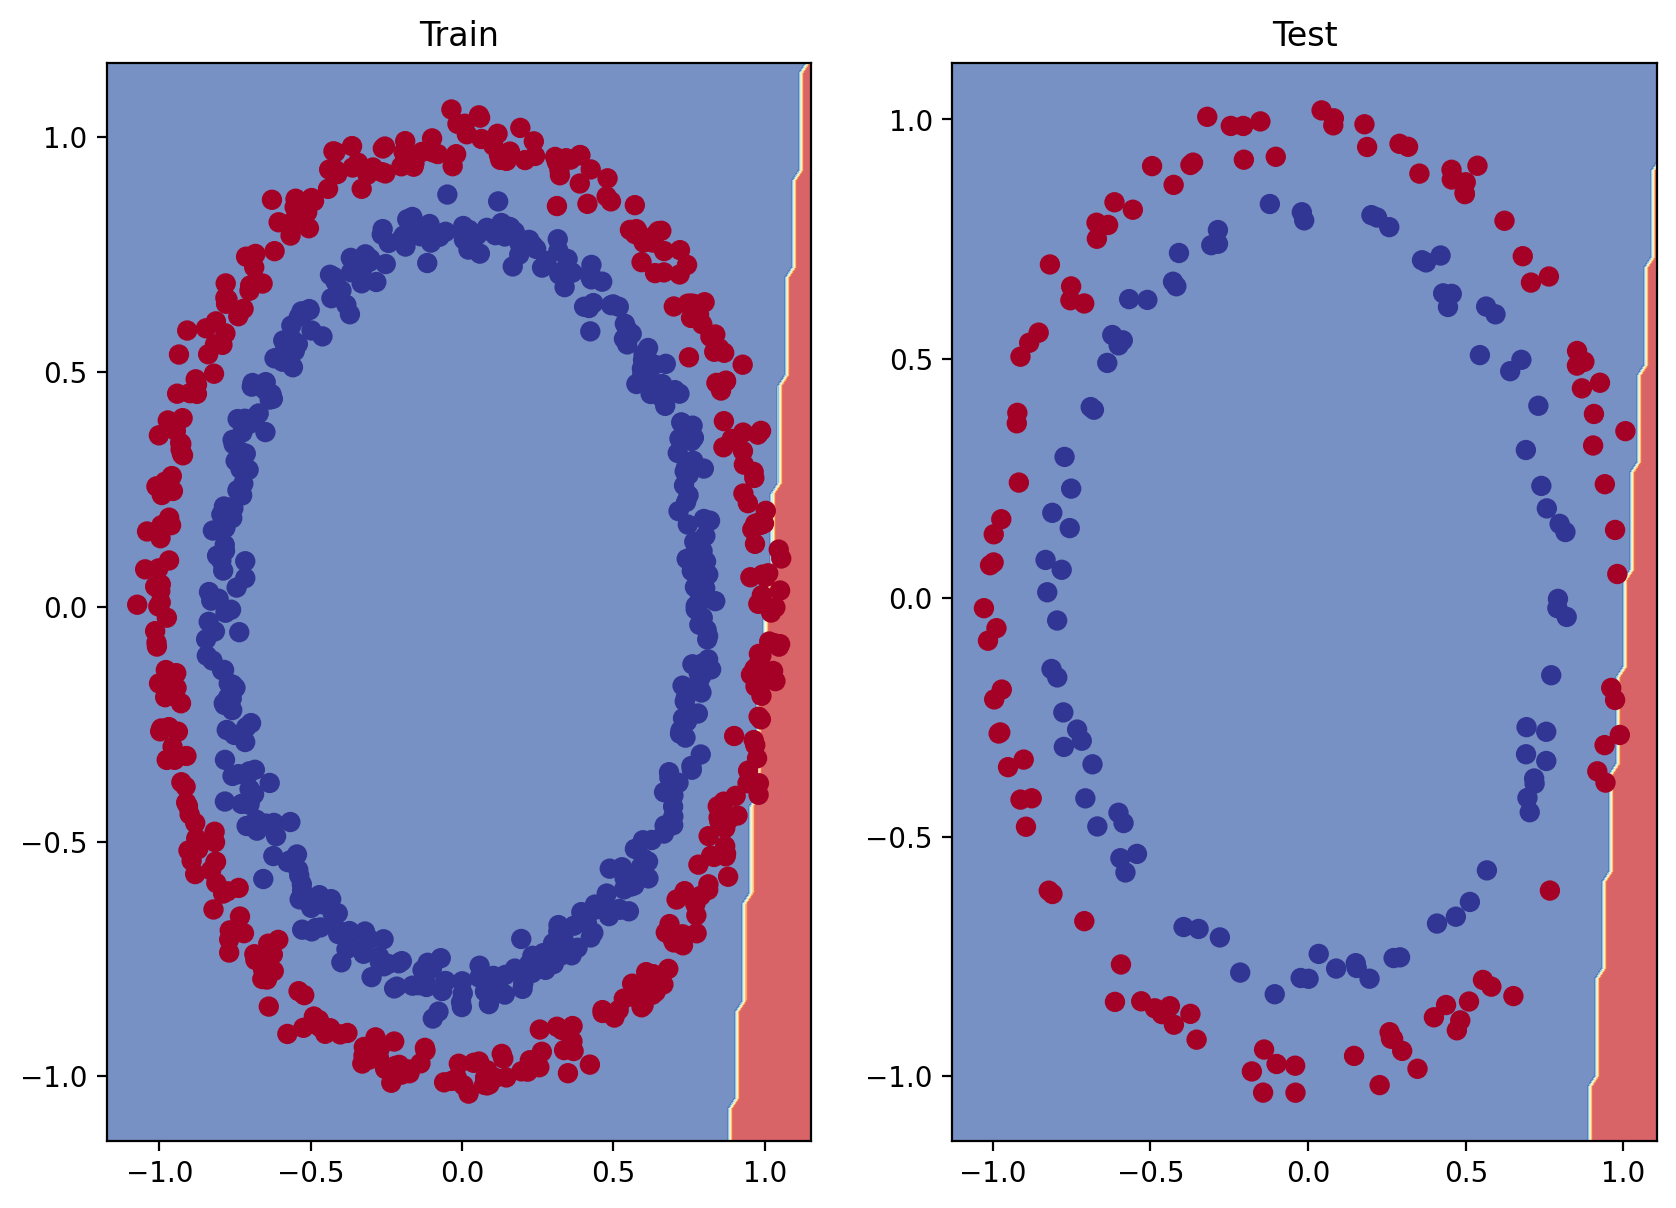

In [32]:
# Plot decision boundary of the model
plt.figure(figsize=(10, 7), dpi=200)
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)
* Add more layers
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [33]:
class CircleModelV1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_1 = torch.nn.Linear(in_features=2,
                                              out_features=10)
        self.linear_layer_2 = torch.nn.Linear(in_features=10,
                                              out_features=10)
        self.linear_layer_3 = torch.nn.Linear(in_features=10,
                                              out_features=1)
    def forward(self, x):
        return self.linear_layer_3(self.linear_layer_2(self.linear_layer_1(x)))

In [34]:
model_1 = CircleModelV1()
model_1.to(device=device)
model_1.state_dict()

OrderedDict([('linear_layer_1.weight',
              tensor([[-0.4270, -0.0703],
                      [-0.5786,  0.5476],
                      [-0.2978, -0.6808],
                      [ 0.5792, -0.2255],
                      [-0.0977,  0.3286],
                      [-0.0317, -0.6058],
                      [ 0.1179,  0.3565],
                      [ 0.3747, -0.5031],
                      [ 0.3044, -0.1481],
                      [ 0.1759, -0.1862]], device='cuda:0')),
             ('linear_layer_1.bias',
              tensor([ 0.5406, -0.1774, -0.5009, -0.1880,  0.0912,  0.0385, -0.5458, -0.5668,
                      -0.4756,  0.3802], device='cuda:0')),
             ('linear_layer_2.weight',
              tensor([[-0.0110,  0.1910, -0.0685, -0.1091,  0.0053, -0.0977,  0.0773,  0.0439,
                        0.1373, -0.1589],
                      [-0.0389,  0.2033,  0.0468,  0.1313, -0.0556,  0.2306, -0.1300,  0.0820,
                        0.2300, -0.0396],
                 

In [35]:
loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [36]:
torch.manual_seed(101)
torch.cuda.manual_seed(101)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    train_logits = model_1(X_train).squeeze()
    train_preds = torch.round(torch.sigmoid(train_logits))

    train_loss = loss_fn(train_logits, y_train)
    train_accuracy = accuracy_fn(train_preds, y_train)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(test_preds, y_test)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Training Loss: {train_loss:.5f} | Training Accuracy: {train_accuracy:.2f}% | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_accuracy:.2f}%")


Epoch: 0 | Training Loss: 0.70438 | Training Accuracy: 48.62% | Testing Loss: 0.68628 | Testing Accuracy: 55.50%
Epoch: 100 | Training Loss: 0.69280 | Training Accuracy: 51.38% | Testing Loss: 0.69667 | Testing Accuracy: 44.50%
Epoch: 200 | Training Loss: 0.69270 | Training Accuracy: 51.38% | Testing Loss: 0.69717 | Testing Accuracy: 44.50%
Epoch: 300 | Training Loss: 0.69269 | Training Accuracy: 51.38% | Testing Loss: 0.69731 | Testing Accuracy: 44.50%
Epoch: 400 | Training Loss: 0.69269 | Training Accuracy: 51.38% | Testing Loss: 0.69735 | Testing Accuracy: 44.50%
Epoch: 500 | Training Loss: 0.69269 | Training Accuracy: 51.38% | Testing Loss: 0.69736 | Testing Accuracy: 44.50%
Epoch: 600 | Training Loss: 0.69269 | Training Accuracy: 51.38% | Testing Loss: 0.69736 | Testing Accuracy: 44.50%
Epoch: 700 | Training Loss: 0.69269 | Training Accuracy: 51.38% | Testing Loss: 0.69736 | Testing Accuracy: 44.50%
Epoch: 800 | Training Loss: 0.69269 | Training Accuracy: 51.38% | Testing Loss: 0.

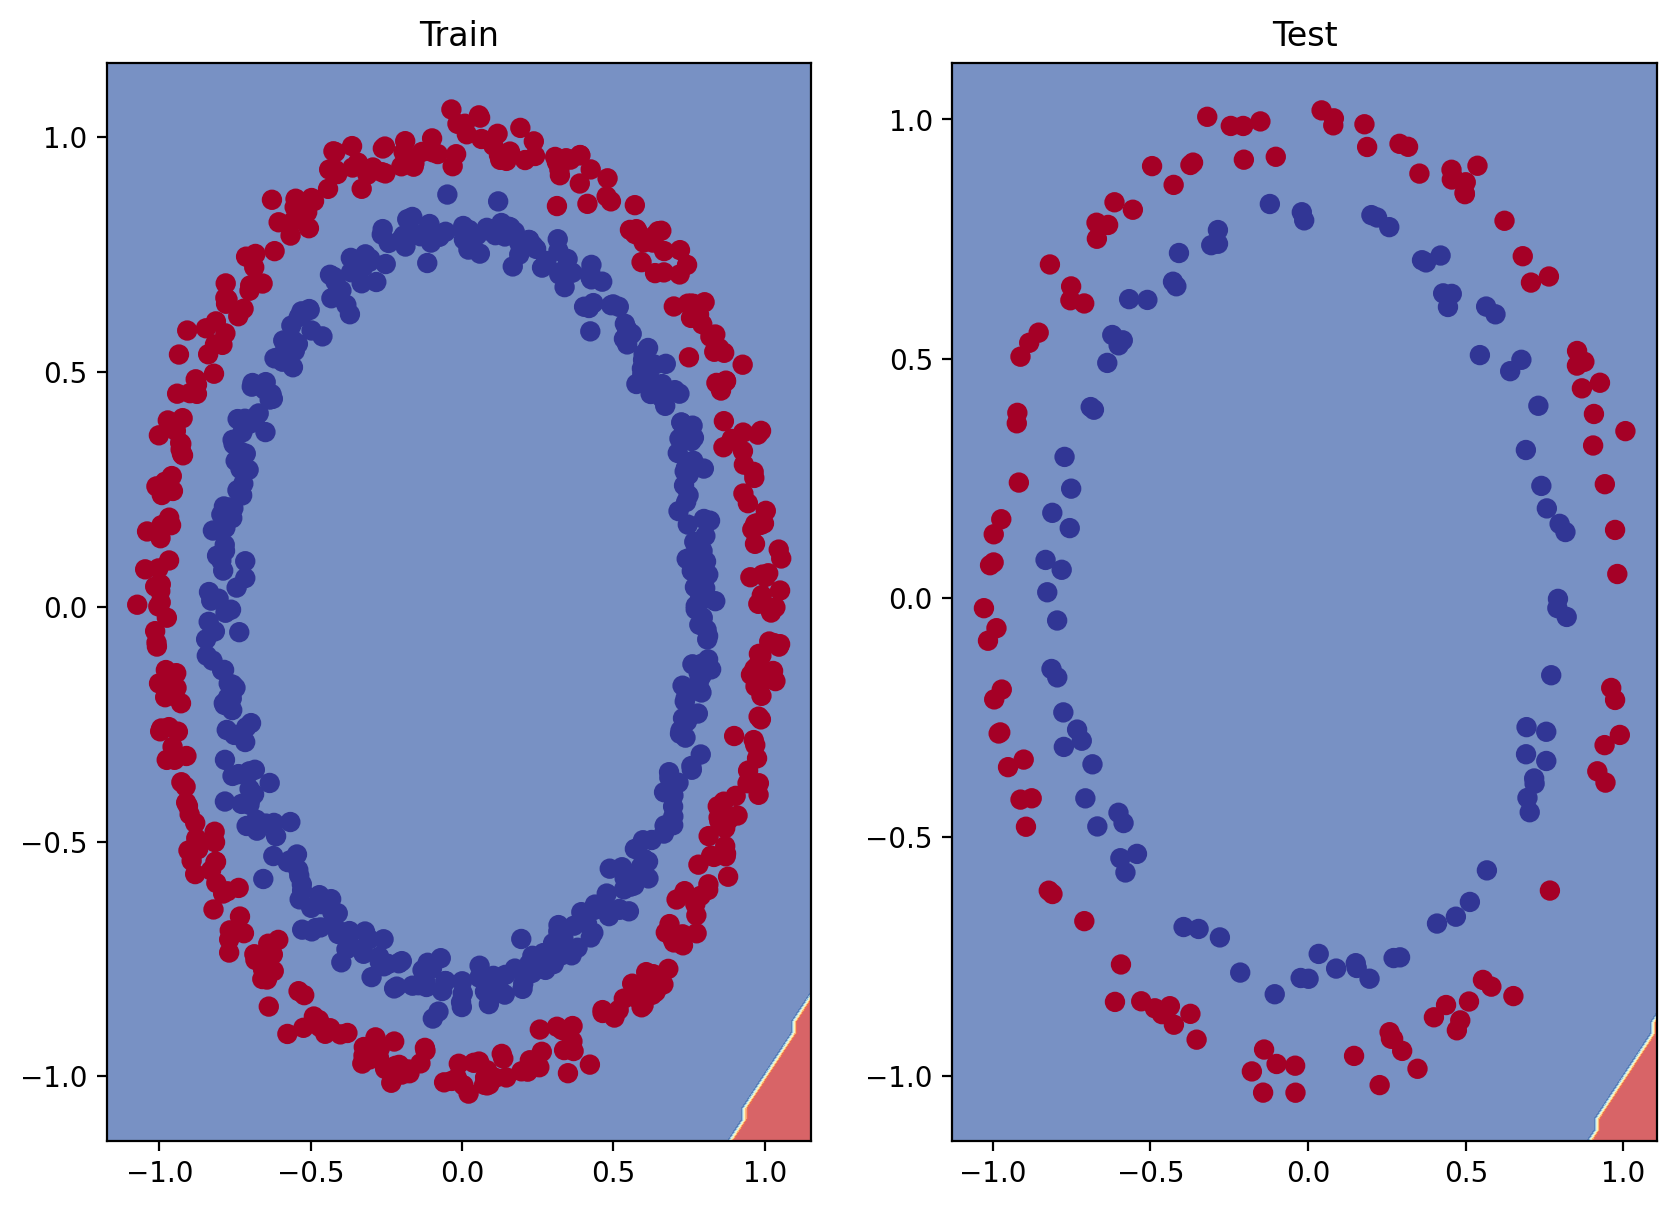

In [37]:
# Plot decision boundary of the model
plt.figure(figsize=(10, 7), dpi=200)
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing the data for the model to fit a straight line

In [38]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [39]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

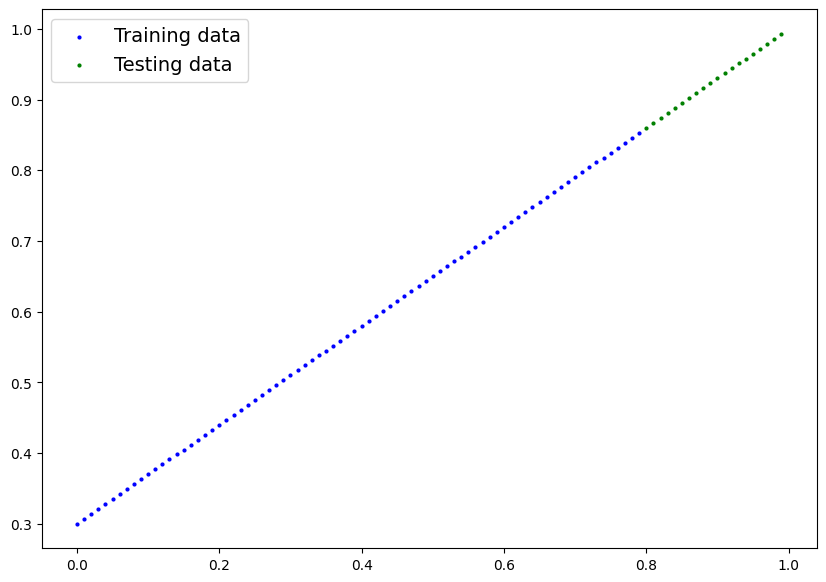

In [40]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting model_1 to fit a straight line

In [41]:
# Same architecture as model_1 (but nn.Sequential())
model_2 = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=10),
    torch.nn.Linear(in_features=10, out_features=10),
    torch.nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [42]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [43]:
torch.manual_seed(101)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    model_2.train()
    train_preds = model_2(X_train_regression)
    train_loss = loss_fn(train_preds, y_train_regression)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_preds = model_2(X_test_regression)
    test_loss = loss_fn(test_preds, y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Training Loss: {train_loss:.5f} | Testing Loss: {test_loss:.5f}")

Epoch: 0 | Training Loss: 0.14507 | Testing Loss: 0.12364
Epoch: 100 | Training Loss: 0.12559 | Testing Loss: 0.04983
Epoch: 200 | Training Loss: 0.09954 | Testing Loss: 0.02453
Epoch: 300 | Training Loss: 0.05564 | Testing Loss: 0.01040
Epoch: 400 | Training Loss: 0.05619 | Testing Loss: 0.00592
Epoch: 500 | Training Loss: 0.05400 | Testing Loss: 0.00834
Epoch: 600 | Training Loss: 0.04690 | Testing Loss: 0.01994
Epoch: 700 | Training Loss: 0.06524 | Testing Loss: 0.00851
Epoch: 800 | Training Loss: 0.05988 | Testing Loss: 0.01901
Epoch: 900 | Training Loss: 0.05803 | Testing Loss: 0.01334


In [44]:
# Make predictions on our data
model_2.eval()
with torch.inference_mode():
    y_preds_reg = model_2(X_test_regression)
y_preds_reg

tensor([[0.7393],
        [0.7450],
        [0.7507],
        [0.7564],
        [0.7620],
        [0.7677],
        [0.7734],
        [0.7791],
        [0.7848],
        [0.7904],
        [0.7961],
        [0.8018],
        [0.8075],
        [0.8132],
        [0.8188],
        [0.8245],
        [0.8302],
        [0.8359],
        [0.8416],
        [0.8472]], device='cuda:0')

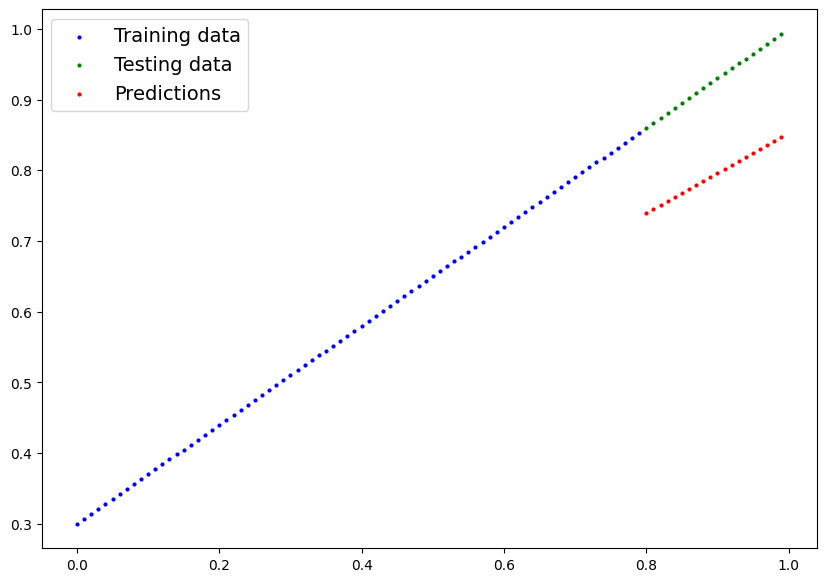

In [45]:
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds_reg.cpu())

## 6.0 Building a model with non-linear activation funtions

### 6.1 Recreating our non-linear data

In [46]:
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=101)

In [47]:
import torch
from sklearn.model_selection import train_test_split
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=101)

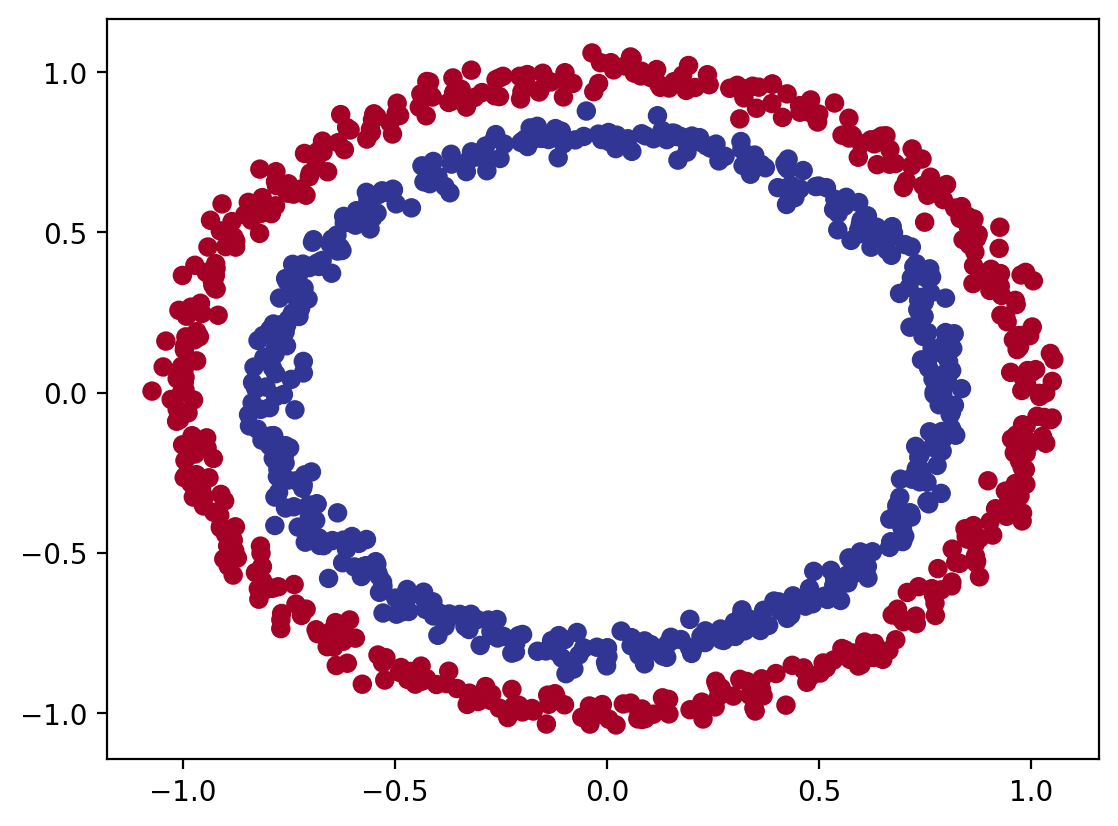

In [49]:
plt.figure(dpi=200)
plt.scatter(X[:,0], X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 6.2 Creating our non-linear model

In [50]:
class CircleModelV2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linearlayer1 = torch.nn.Linear(in_features=2,
                                       out_features=10)
        self.linearlayer2 = torch.nn.Linear(in_features=10,
                                            out_features=10)
        self.linearlayer3 = torch.nn.Linear(in_features=10,
                                            out_features=1)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        return self.linearlayer3(self.relu(self.linearlayer2(self.relu(self.linearlayer1(x)))))
model_3 = CircleModelV2().to(device)
# model_3.to(device)

In [51]:
model_3

CircleModelV2(
  (linearlayer1): Linear(in_features=2, out_features=10, bias=True)
  (linearlayer2): Linear(in_features=10, out_features=10, bias=True)
  (linearlayer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [52]:
model_3.state_dict()

OrderedDict([('linearlayer1.weight',
              tensor([[-0.4270, -0.0703],
                      [-0.5786,  0.5476],
                      [-0.2978, -0.6808],
                      [ 0.5792, -0.2255],
                      [-0.0977,  0.3286],
                      [-0.0317, -0.6058],
                      [ 0.1179,  0.3565],
                      [ 0.3747, -0.5031],
                      [ 0.3044, -0.1481],
                      [ 0.1759, -0.1862]], device='cuda:0')),
             ('linearlayer1.bias',
              tensor([ 0.5406, -0.1774, -0.5009, -0.1880,  0.0912,  0.0385, -0.5458, -0.5668,
                      -0.4756,  0.3802], device='cuda:0')),
             ('linearlayer2.weight',
              tensor([[-0.0110,  0.1910, -0.0685, -0.1091,  0.0053, -0.0977,  0.0773,  0.0439,
                        0.1373, -0.1589],
                      [-0.0389,  0.2033,  0.0468,  0.1313, -0.0556,  0.2306, -0.1300,  0.0820,
                        0.2300, -0.0396],
                      [

In [53]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training our non-linear model

In [54]:
torch.manual_seed(101)
torch.cuda.manual_seed(101)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_3.train()
    train_logits = model_3(X_train).squeeze()
    train_preds = torch.round(torch.sigmoid(train_logits))

    train_loss = loss_fn(train_logits, y_train)
    train_accuracy = accuracy_fn(train_preds, y_train)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_accuracy = accuracy_fn(test_preds, y_test)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Training Loss: {train_loss:.5f} | Training Accuracy: {train_accuracy:.2f}% | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_accuracy:.2f}%")

Epoch: 0 | Training Loss: 0.69534 | Training Accuracy: 45.38% | Testing Loss: 0.13322 | Testing Accuracy: 48.00%
Epoch: 100 | Training Loss: 0.69294 | Training Accuracy: 55.12% | Testing Loss: 0.13322 | Testing Accuracy: 47.50%
Epoch: 200 | Training Loss: 0.69084 | Training Accuracy: 54.00% | Testing Loss: 0.13322 | Testing Accuracy: 47.50%
Epoch: 300 | Training Loss: 0.68922 | Training Accuracy: 58.25% | Testing Loss: 0.13322 | Testing Accuracy: 54.50%
Epoch: 400 | Training Loss: 0.68709 | Training Accuracy: 61.75% | Testing Loss: 0.13322 | Testing Accuracy: 57.50%
Epoch: 500 | Training Loss: 0.68405 | Training Accuracy: 72.25% | Testing Loss: 0.13322 | Testing Accuracy: 71.50%
Epoch: 600 | Training Loss: 0.67957 | Training Accuracy: 73.25% | Testing Loss: 0.13322 | Testing Accuracy: 72.00%
Epoch: 700 | Training Loss: 0.67280 | Training Accuracy: 66.88% | Testing Loss: 0.13322 | Testing Accuracy: 67.00%
Epoch: 800 | Training Loss: 0.66229 | Training Accuracy: 68.25% | Testing Loss: 0.

### 6.4 Evaluating our non-linear model

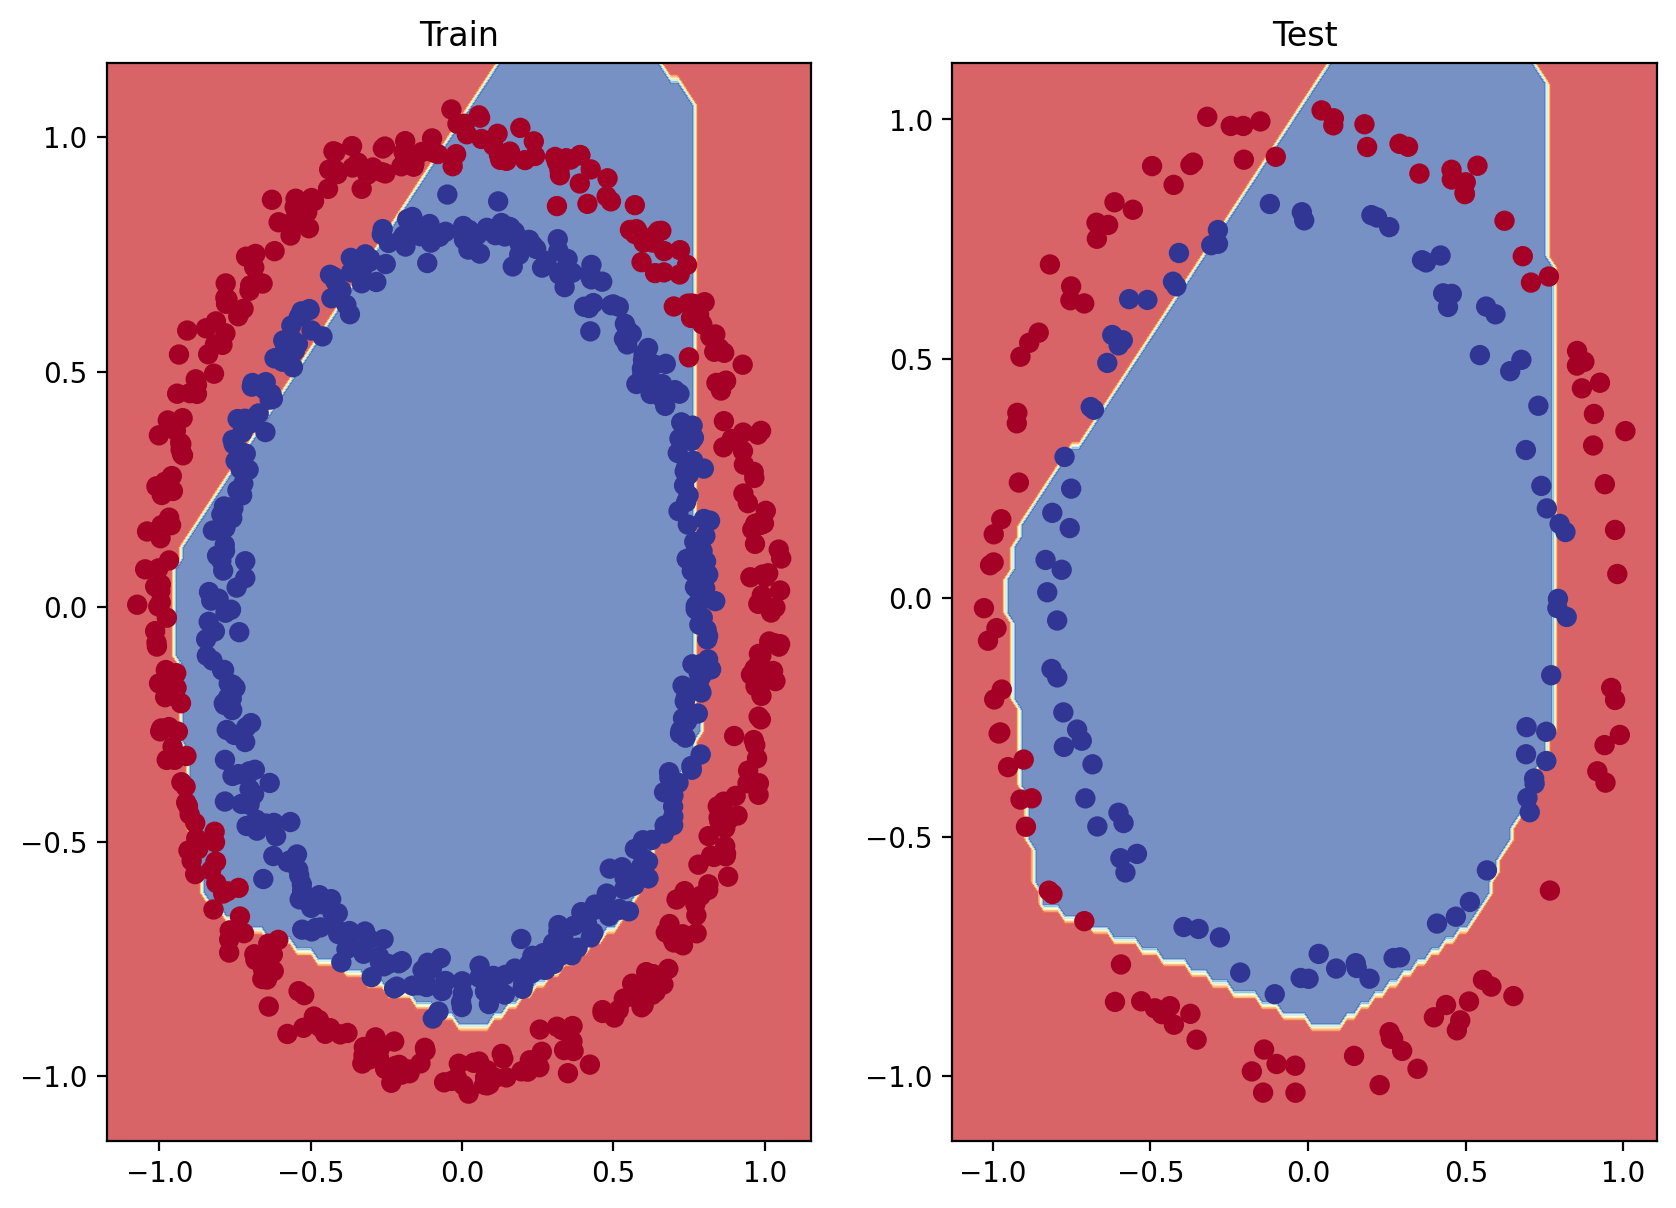

In [55]:
# Plot decision boundary of the model
plt.figure(figsize=(10, 7), dpi=200)
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

### 6.5 Replicating non-linear functions using pure pytorch

In [56]:
A = torch.arange(-10, 11, 1, dtype=torch.float32)

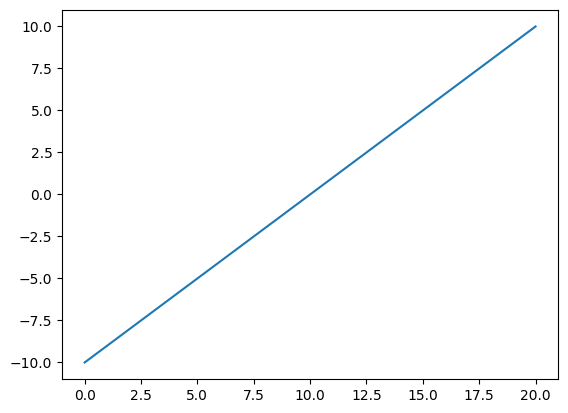

In [57]:
plt.plot(A);

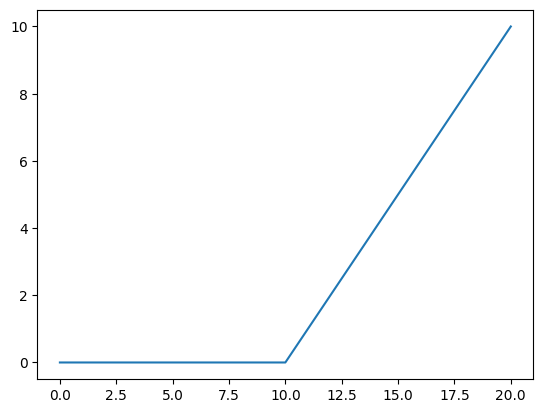

In [58]:
plt.plot(torch.relu(A));

In [59]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)


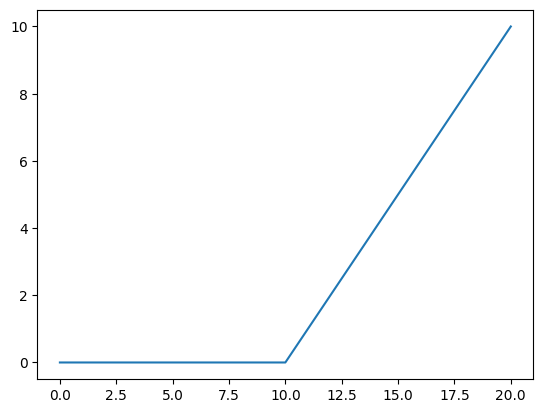

In [60]:
plt.plot(relu(A));

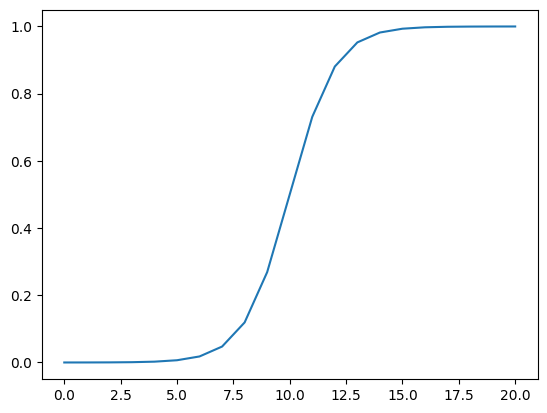

In [61]:
plt.plot(torch.sigmoid(A));

In [62]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

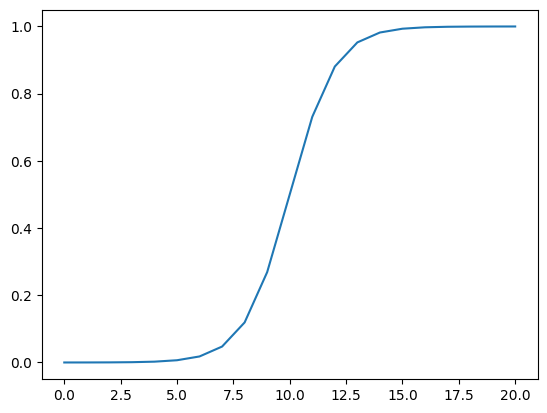

In [63]:
plt.plot(sigmoid(A));

## 7.0 Creating a multi-class classification

### 7.1 Creating data

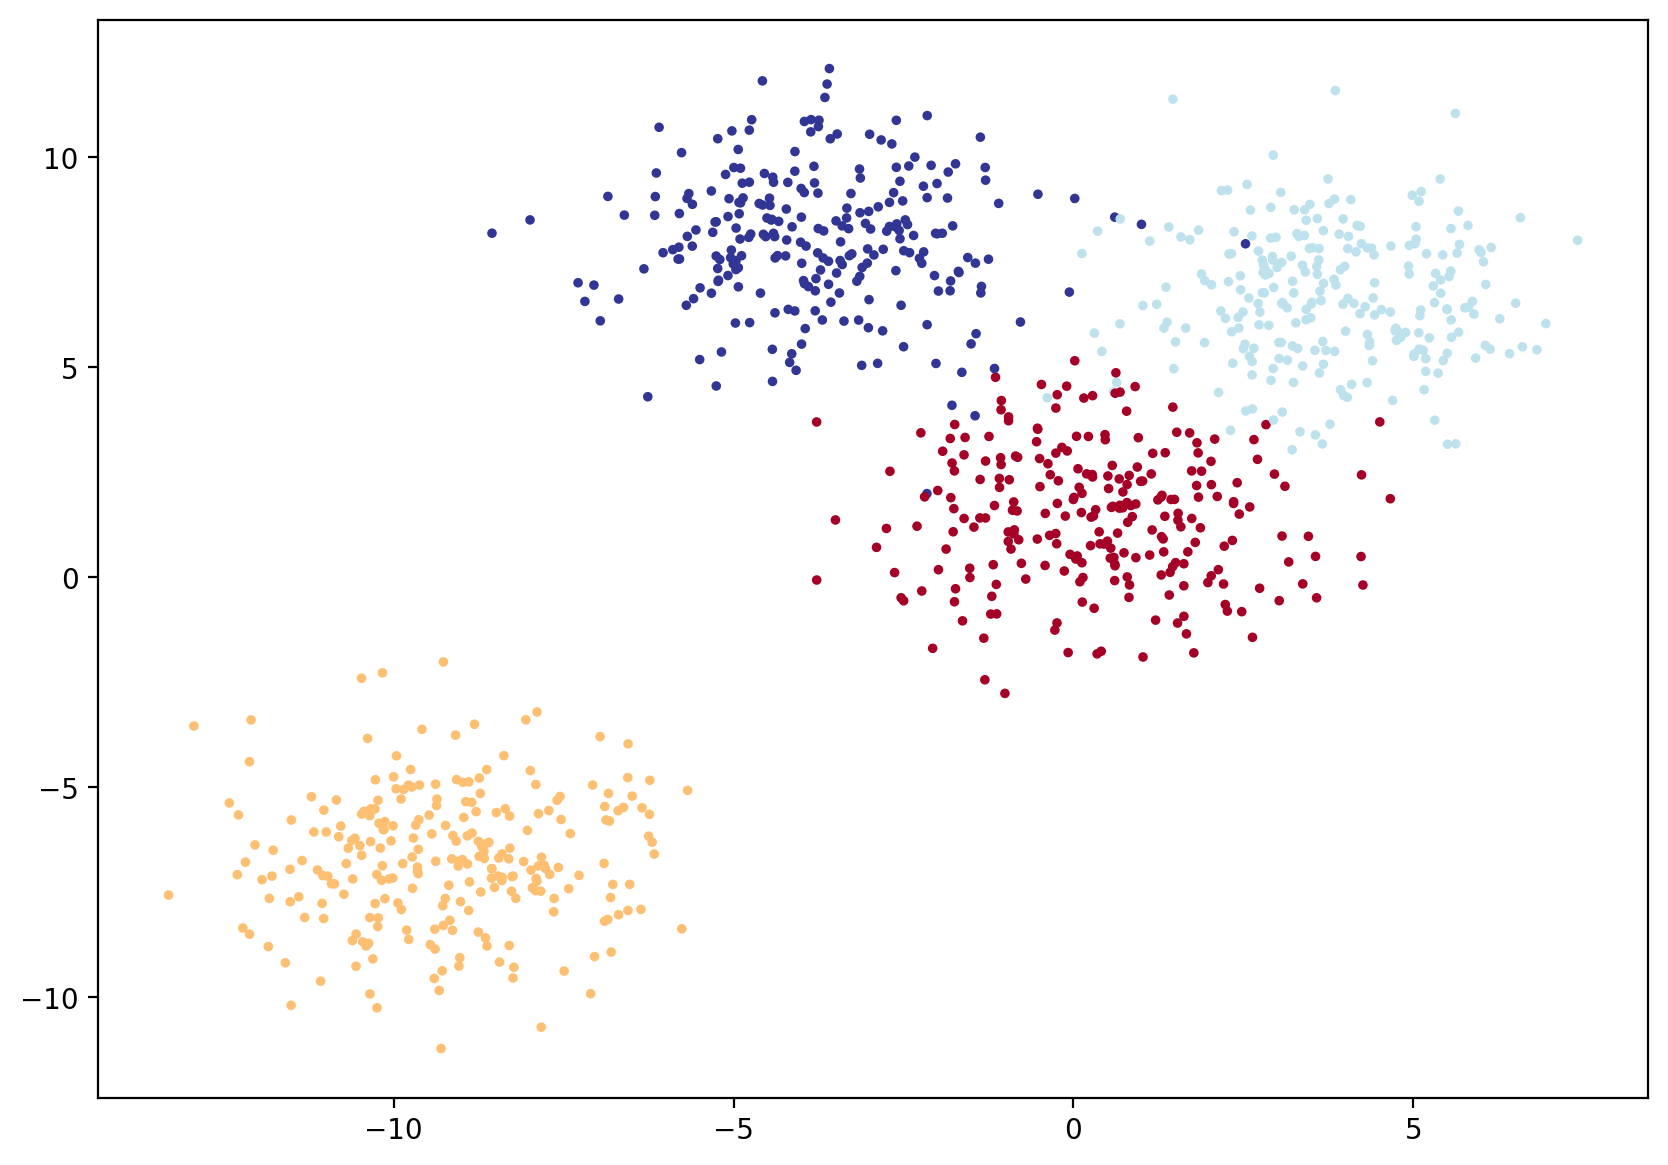

In [64]:
from sklearn.datasets import make_blobs
n_samples = 1000
num_clusters = 4
num_features = 2
random_seed = 101

X_blob, y_blob = make_blobs(n_samples=n_samples,
                            n_features=num_features,
                            centers=num_clusters,
                            cluster_std=1.5,
                            random_state=random_seed)

X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)

X_train_blob, X_test_blob, y_train_blob, y_test_blob = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=random_seed)

plt.figure(figsize=(10, 7), dpi=200)
plt.scatter(X_blob[:, 0],
            X_blob[:, 1],
            s=6,
            c=y_blob,
            cmap=plt.cm.RdYlBu)


## 7.2 Creating a model

In [65]:
class BlobModel(torch.nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = torch.nn.Sequential(
            torch.nn.Linear(in_features=input_features, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device=device)

In [66]:
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 7.3 Creating loss and optimizer for our model

In [67]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.01)

### 7.4 Making sample predictions with our model

In [68]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test_blob.to(device))
y_logits[:10]

tensor([[ 0.0812,  0.0923, -0.2869,  0.1207],
        [-0.5603,  0.0259, -0.6091, -1.5136],
        [-0.2356,  0.1402, -0.4188, -0.0452],
        [-0.2453, -0.0985, -0.2323, -0.0912],
        [-0.2300, -0.0918, -0.2250, -0.1121],
        [-0.2523,  0.0883, -0.3695, -0.0620],
        [-0.5762,  0.0051, -0.6601, -1.2951],
        [-0.6079,  0.1479, -0.8314, -1.4628],
        [-0.3445,  0.0346, -0.4433, -0.3997],
        [-0.3280,  0.2084, -0.6204, -0.4836]], device='cuda:0')

In [69]:
y_pred_probs = torch.softmax(y_logits, dim=1)

In [70]:
y_pred_probs[:5], y_test_blob[:5]

(tensor([[0.2671, 0.2701, 0.1849, 0.2779],
         [0.2418, 0.4346, 0.2303, 0.0932],
         [0.2223, 0.3237, 0.1851, 0.2689],
         [0.2305, 0.2670, 0.2335, 0.2690],
         [0.2337, 0.2684, 0.2349, 0.2630]], device='cuda:0'),
 tensor([1, 3, 2, 1, 1]))

In [71]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5], y_test_blob[:5]

(tensor([3, 1, 1, 3, 1], device='cuda:0'), tensor([1, 3, 2, 1, 1]))

### 7.5 Training our model

In [72]:
torch.manual_seed(101)
torch.cuda.manual_seed(101)

X_train_blob, y_train_blob = X_train_blob.to(device), y_train_blob.to(device)
X_test_blob, y_test_blob = X_test_blob.to(device), y_test_blob.to(device)

epochs = 1000

for epoch in range(epochs):
    model_4.train()
    train_logits = model_4(X_train_blob)
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

    train_loss = loss_fn(train_logits, y_train_blob)
    train_accuracy = accuracy_fn(train_preds, y_train_blob)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test_blob)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test_blob)
        test_accuracy = accuracy_fn(test_preds, y_test_blob)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Training Loss: {train_loss:.5f} | Training Accuracy: {train_accuracy:.2f}% | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_accuracy:.2f}%")



Epoch: 0 | Training Loss: 1.67974 | Training Accuracy: 15.62% | Testing Loss: 1.66264 | Testing Accuracy: 14.50%
Epoch: 10 | Training Loss: 1.49658 | Training Accuracy: 25.25% | Testing Loss: 1.48684 | Testing Accuracy: 24.50%
Epoch: 20 | Training Loss: 1.37432 | Training Accuracy: 25.25% | Testing Loss: 1.36620 | Testing Accuracy: 25.00%
Epoch: 30 | Training Loss: 1.27521 | Training Accuracy: 43.00% | Testing Loss: 1.27077 | Testing Accuracy: 46.00%
Epoch: 40 | Training Loss: 1.19264 | Training Accuracy: 49.88% | Testing Loss: 1.19110 | Testing Accuracy: 50.00%
Epoch: 50 | Training Loss: 1.11877 | Training Accuracy: 56.88% | Testing Loss: 1.11916 | Testing Accuracy: 58.00%
Epoch: 60 | Training Loss: 1.05205 | Training Accuracy: 61.62% | Testing Loss: 1.05355 | Testing Accuracy: 61.50%
Epoch: 70 | Training Loss: 0.99181 | Training Accuracy: 64.50% | Testing Loss: 0.99396 | Testing Accuracy: 65.00%
Epoch: 80 | Training Loss: 0.93728 | Training Accuracy: 66.00% | Testing Loss: 0.94009 | 

### 7.6 Evaluating our model

In [73]:
model_4.eval()
with torch.inference_mode():
    test_logits = model_4(X_test_blob)

test_pred_probs = torch.softmax(test_logits, dim=1)
test_preds = torch.argmax(test_pred_probs,dim=1)

In [74]:
test_preds[:10]

tensor([1, 3, 2, 1, 1, 0, 3, 2, 0, 2], device='cuda:0')

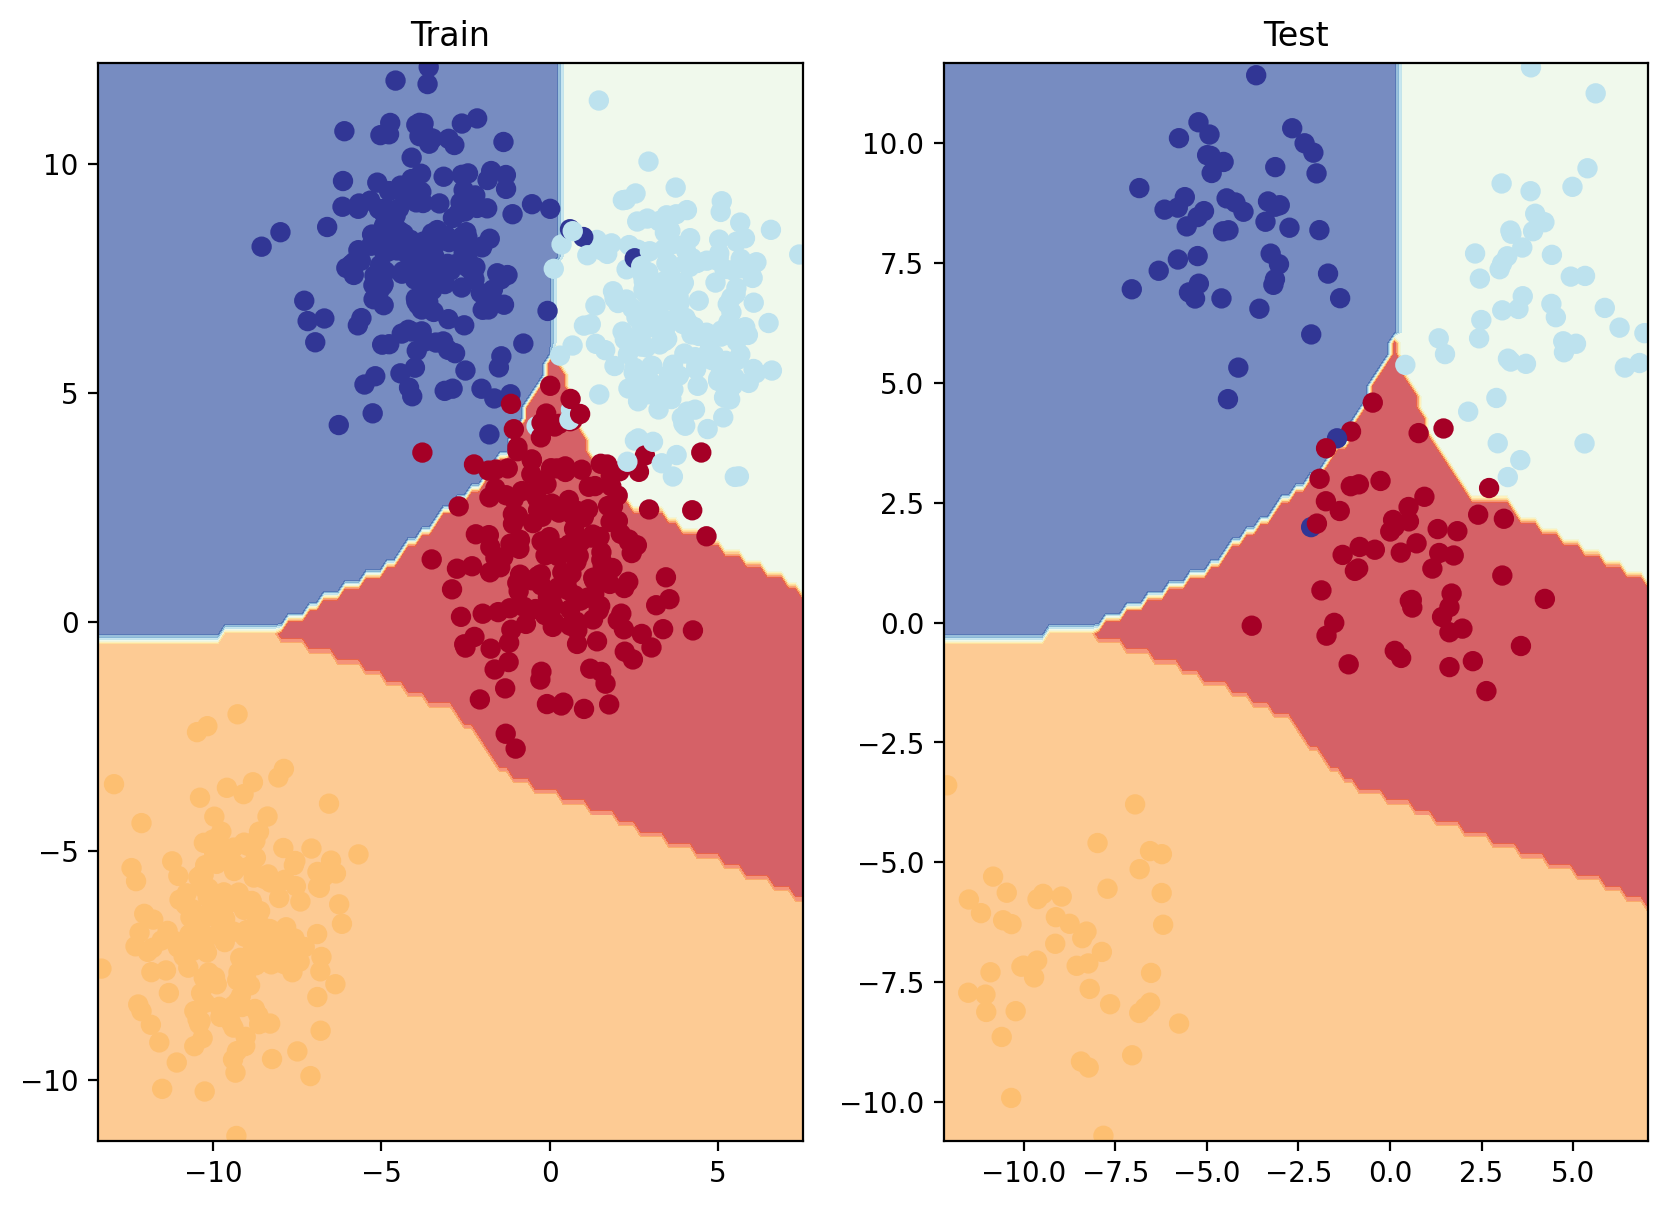

In [75]:
# Plot decision boundary of the model
plt.figure(figsize=(10, 7), dpi=200)
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train_blob, y_train_blob)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test_blob, y_test_blob)

In [80]:
from torchmetrics import Accuracy
torchmetrics_accuracy = Accuracy(task="multiclass" ,num_classes=4).to(device)

torchmetrics_accuracy(test_preds, y_test_blob)

tensor(0.9800, device='cuda:0')